#### LOAD PACKAGES

In [61]:
import os
import yaml
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
# from func import *
# from helpers import *
from xgboost import XGBClassifier
from sklearn. metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [62]:
CONFIG_PATH = Path("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/config/params.yaml")
with open(CONFIG_PATH) as file:
    params_ = yaml.safe_load(file)
input_files = params_['evaluate']['input']
# output_path = Path(params_['evaluate']['output'][0])
output_path = Path("/mnt/c/Users/nahomw/Desktop/from_mac/nahomworku/Desktop/uthealth/gra_project/synthetic-population/src/experiments/experiment_2")
output_path.mkdir(parents=True, exist_ok=True)
df_train = pd.read_csv(input_files[0], low_memory=False) #ctgan generated data
df_test = pd.read_csv(input_files[1], low_memory=False) # test dataset
df_train2 = pd.read_csv(input_files[2], low_memory=False) # train dataset


In [63]:
df = pd.concat([df_test, df_train2])
df = df.drop(columns=['FIRST_PAYMENT_SRC','RECORD_ID'])
df.dropna(inplace=True)
df.columns

Index(['DISCHARGE', 'TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION', 'PAT_ZIP',
       'PAT_COUNTY', 'PUBLIC_HEALTH_REGION', 'PAT_STATUS', 'SEX_CODE', 'RACE',
       'ETHNICITY', 'ADMIT_WEEKDAY', 'LENGTH_OF_STAY', 'PAT_AGE', 'APR_MDC'],
      dtype='object')

In [23]:
df_output = df['APR_MDC']
df_input = df.drop(columns=['APR_MDC'])



#### GENERATE DEMOGRAPHIC DATA FROM 

In [24]:
def preprocess(df):

    df_ = df.copy()
    cat_cols = ['DISCHARGE','TYPE_OF_ADMISSION', 'SOURCE_OF_ADMISSION',
                'PUBLIC_HEALTH_REGION', 'PAT_STATUS', 'SEX_CODE', 'RACE', 'ETHNICITY', 'ADMIT_WEEKDAY','PAT_AGE']
    for col in cat_cols:
        df_[col] = df_[col].astype(str)
        le = LabelEncoder()
        df_[col] = le.fit_transform(df_[col])
    num_cols = ['LENGTH_OF_STAY']
    X = df_[cat_cols + num_cols]
    y = df_['APR_MDC']
    return X,y
X,y= preprocess(df)
X.shape, y.shape
df_new = pd.concat([X,y], axis=1)
df_new.head()



,DISCHARGE,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,PAT_AGE,LENGTH_OF_STAY,APR_MDC
1,1,0,0,7,0,0,3,0,2,20,13,5
2,1,0,0,4,0,1,3,3,6,16,1,6
3,1,0,2,4,11,0,3,3,4,18,12,7
5,1,0,0,7,0,1,3,3,5,18,6,4
6,1,0,0,8,15,1,3,2,0,21,9,1


In [25]:
df_new

,DISCHARGE,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,PAT_AGE,LENGTH_OF_STAY,APR_MDC
1,1,0,0,7,0,0,3,0,2,20,13,5
2,1,0,0,4,0,1,3,3,6,16,1,6
3,1,0,2,4,11,0,3,3,4,18,12,7
5,1,0,0,7,0,1,3,3,5,18,6,4
6,1,0,0,8,15,1,3,2,0,21,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...
354747,1,0,0,8,0,0,3,2,6,10,2,14
354750,1,0,0,1,13,1,2,3,1,19,8,5
354751,1,0,0,4,17,1,4,2,3,16,13,10
354752,1,0,0,4,15,1,2,2,5,19,5,5


In [26]:
import numpy as np
import pandas as pd

class ConditionalGenerator:
    def __init__(self):
        self.conditional_marginals = None
        self.features = None
        self.output_col = None
        self.categorical_features = None

    def fit(self, df, output_col='APR_MDC', features=None):
        """
        Learn conditional distributions P(features | APR_MDC) from categorical data.
        """
        if features is None:
            features = [c for c in df.columns if c != output_col]

        self.features = features
        self.output_col = output_col
        self.categorical_features = features

        self.conditional_marginals = {}

        # Learn conditional distributions for each APR_MDC value
        for apr_val, group in df.groupby(output_col):
            self.conditional_marginals[apr_val] = {}

            for feat in self.categorical_features:
                counts = group[feat].value_counts(normalize=True)
                self.conditional_marginals[apr_val][feat] = counts.to_dict()

        print("✅ Learned categorical conditional distributions P(feature | APR_MDC)")
        return self

    def fit_globals(self, df):
        """
        Learn global (unconditional) categorical distributions for fallback sampling.
        """
        self.global_probs = {
            feat: df[feat].value_counts(normalize=True).to_dict()
            for feat in self.categorical_features
        }
        return self

    def generate(self, df_output):
        """
        Generate new synthetic samples for given APR_MDC values (categorical only).
        """
        # Handle both Series and DataFrame inputs
        if isinstance(df_output, pd.Series):
            df_output = pd.DataFrame({self.output_col: df_output})

        synthetic_records = []

        for _, row in df_output.iterrows():
            apr_val = row[self.output_col]
            probs = self.conditional_marginals.get(apr_val, None)
            synthetic_row = {self.output_col: apr_val}

            for feat in self.categorical_features:
                if probs and feat in probs:
                    choices, p = zip(*probs[feat].items())
                    synthetic_row[feat] = np.random.choice(
                        choices, p=np.array(p) / np.sum(p)
                    )
                else:
                    # fallback to overall marginal
                    choices, p = zip(*self.global_probs[feat].items())
                    synthetic_row[feat] = np.random.choice(
                        choices, p=np.array(p) / np.sum(p)
                    )

            synthetic_records.append(synthetic_row)

        synthetic_df = pd.DataFrame(synthetic_records)
        print(f"✅ Generated {len(synthetic_df)} synthetic categorical samples conditioned on {self.output_col}")

        return synthetic_df


In [27]:
df_new.dtypes

DISCHARGE               int64
TYPE_OF_ADMISSION       int64
SOURCE_OF_ADMISSION     int64
PUBLIC_HEALTH_REGION    int64
PAT_STATUS              int64
SEX_CODE                int64
RACE                    int64
ETHNICITY               int64
ADMIT_WEEKDAY           int64
PAT_AGE                 int64
LENGTH_OF_STAY          int64
APR_MDC                 int64
dtype: object

In [28]:
synthetic_df.head()

,APR_MDC,DISCHARGE,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,PAT_AGE,LENGTH_OF_STAY
0,4,1,0,0,9,0,0,3,3,2,2,2
1,7,1,0,0,7,0,0,2,3,6,17,2
2,14,1,0,1,8,0,0,3,3,1,9,4
3,5,1,0,0,5,0,1,3,3,2,20,1
4,5,1,0,0,7,13,1,3,3,0,24,2


In [29]:
# 1️⃣ Fit model
import time
start_time = time.time()
model = ConditionalGenerator().fit(df_new)
model.fit_globals(df_new)  # learns fallback (global) distributions

# 2️⃣ Suppose df_output contains APR_MDC values only
# df_output = df["APR_MDC"].sample(len(df), random_state=42)
df_output = df["APR_MDC"].sample(50000, random_state=42)



# 3️⃣ Generate synthetic samples conditioned on APR_MDC
synthetic_df = model.generate(df_output)
end_time = time.time()
print(f"Time elapsed:{end_time - start_time}")
# synthetic_df['APR_MDC'] = df_output
# synthetic_df.head()
# df_gen = pd.concat([synthetic_df,df_output])
df_gen = synthetic_df

✅ Learned categorical conditional distributions P(feature | APR_MDC)


KeyboardInterrupt: 

In [30]:
df_gen.shape


(50000, 12)

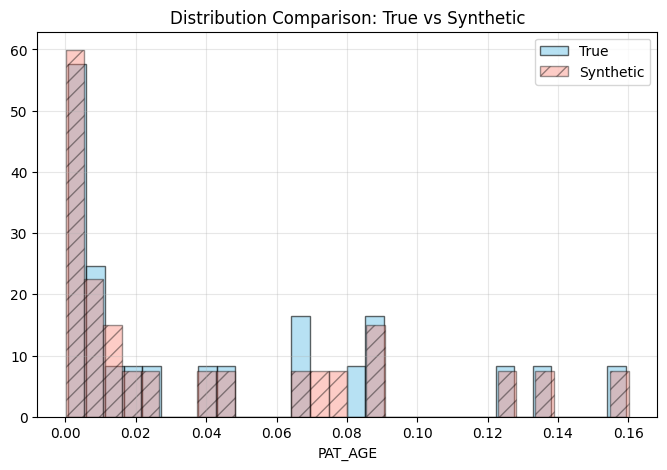

Jensen–Shannon similarity: 77.52%


In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import jensenshannon

def dist_match(true_data, synthetic_data, bins=30):
    plt.figure(figsize=(8,5))
    
    # Compute histogram densities
    true_counts, true_bins = np.histogram(true_data, bins=bins, density=True)
    synth_counts, synth_bins = np.histogram(synthetic_data, bins=bins, density=True)
    
    # Use different bar shapes (solid vs hatch)
    plt.hist(true_data, bins=true_bins, alpha=0.6, label="True", color='skyblue', edgecolor='black', density=True)
    plt.hist(synthetic_data, bins=synth_bins, alpha=0.4, label="Synthetic", 
             color='salmon', edgecolor='black', hatch='//', density=True)
    
    plt.xlabel("PAT_AGE")
    # plt.ylabel("Density")
    plt.title("Distribution Comparison: True vs Synthetic")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Align the histogram arrays for Jensen–Shannon
    min_len = min(len(true_counts), len(synth_counts))
    js_distance = jensenshannon(true_counts[:min_len], synth_counts[:min_len])
    
    print(f'Jensen–Shannon similarity: {(1 - js_distance) * 100:.2f}%')

# Example usage
dist_match(df_gen['APR_MDC'].value_counts(normalize=True), df_new['APR_MDC'].value_counts(normalize=True))


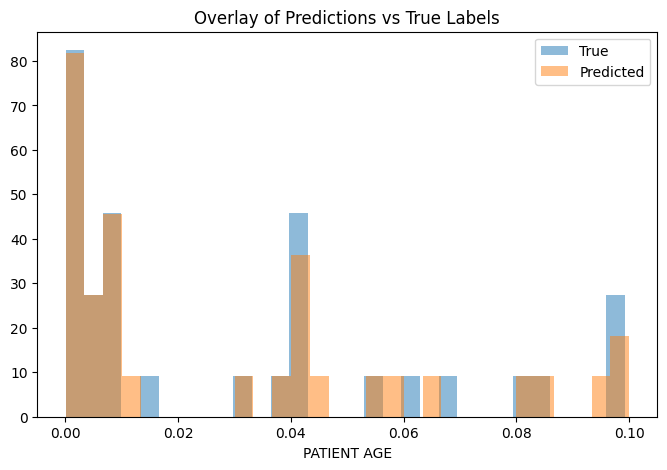

Jenson Shannon based similarity: Similarity between actual and synthetic datasets is 0.9944144089056222 percent


In [59]:
def dist_match(data, pred, class_):
    plt.figure(figsize=(8,5))
    plt.hist(data, bins=30, alpha=0.5, label="True", density=True)
    plt.hist(pred, bins=30, alpha=0.5, label="Predicted", density=True)

    plt.xlabel(class_)
    # plt.ylabel("Density")
    plt.title("Overlay of Predictions vs True Labels")
    plt.legend()
    plt.show()

    return print(f'Jenson Shannon based similarity: Similarity between actual and synthetic datasets is {(1-jensenshannon(data,pred) )} percent')
dist_match(df_gen['PAT_AGE'].value_counts(normalize=True), df_new['PAT_AGE'].value_counts(normalize=True), class_="PATIENT AGE")

In [37]:
X = df_gen['APR_MDC']
y = df_gen['PAT_AGE']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
X_train.shape, y_train.shape
model = XGBClassifier()
model.fit(X_train, y_train)
print(f"Accuracy:{accuracy_score(model.predict(X_test), y_test )}") 

Accuracy:0.1282


### FOR LARGER DISEASE GROUP

In [38]:
(df_gen['APR_MDC'].value_counts(normalize=True) * 100).head()

APR_MDC
5     15.930
18    13.658
4     12.482
6      8.846
14     8.808
Name: proportion, dtype: float64

In [39]:
df_large_synth = df_gen[df_gen['APR_MDC'] == 5]
df_large_real = df_new[df_gen['APR_MDC'] == 5]

dist_match(df_large_synth['PAT_AGE'].value_counts(normalize=True), df_large_real['PAT_AGE'].value_counts(normalize=True))

/tmp/ipykernel_80912/2258166001.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_large_real = df_new[df_gen['APR_MDC'] == 5]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [40]:
df_new.

SyntaxError: invalid syntax (1275476491.py, line 1)

### FOR THE RAREST DISEASE GROUP

In [41]:
(df_gen['APR_MDC'].value_counts(normalize=True) * 100).tail(7)

APR_MDC
25    0.518
13    0.478
23    0.470
12    0.208
2     0.200
15    0.164
22    0.068
Name: proportion, dtype: float64

In [42]:
df_gen[df_gen['APR_MDC'] == 12]['PAT_AGE'].value_counts().count(), df_new[df_new['APR_MDC'] == 12]['PAT_AGE'].value_counts().count()



(np.int64(17), np.int64(27))

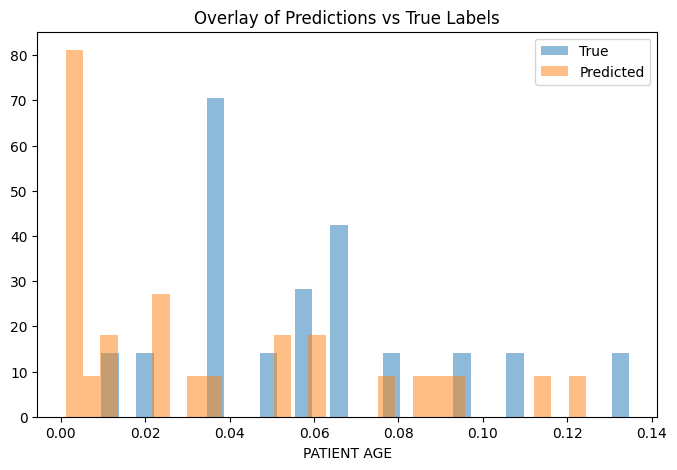

ValueError: operands could not be broadcast together with shapes (17,) (27,) 

In [43]:
df_small_synth = df_gen[df_gen['APR_MDC'] == 12]
df_small_real = df_new[df_new['APR_MDC'] == 12]

df_small_synth['APR_MDC'].head(),df_small_real['APR_MDC'].head()

dist_match(df_small_synth['PAT_AGE'].value_counts(normalize=True), df_small_real['PAT_AGE'].value_counts(normalize=True))

In [44]:
# (df=df, features=df.columns,n_samples=df.shape[0], target_marginals, tol=1e-5, max_iter=100)

### KNN MODEL EXPERIMENT 3

In [51]:
def train_model(model, train_data, test_data): 

    X_train,y_train= preprocess(train_data)
    X_test,y_test= preprocess(test_data)

    # X_train = train_data.drop(columns = ['APR_MDC'])
    # y_train = train_data['APR_MDC']

    # X_test = train_data.drop(columns = ['APR_MDC'])
    # y_test = train_data['APR_MDC']
    # train_data = train_test_split(X_train,y_train, test_size=0.2)
    model_ = model.fit(X_train, y_train)
    pred = model_.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, pred)}")
    df_pred = test_data
    df_pred['pred'] = pred
    return df_pred
# model = KNeighborsClassifier(n_neighbors=100, n_jobs=4)
model = XGBClassifier(n_estimators=200, max_depth=15, n_jobs=4)
df_pred = train_model(model,train_data=df_train2, test_data=df_test)

Accuracy: 0.2501663114929698


In [52]:
df_train2.shape, df_test.shape, int(df_train2.shape[0])+int(df_test.shape[0])

((354754, 16), (88689, 17), 443443)

In [53]:
### Train model using synthetic dataset and predict using real Dataset (TSTR)
df.shape

(378782, 14)

In [48]:
df.head()

,DISCHARGE,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_ZIP,PAT_COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,APR_MDC
1,2023Q1,1,1,77068,201.0,6.0,1,F,4,1,3,13,18,5
2,2023Q1,1,1,75160,257.0,3.0,1,M,4,2.0,7,1,14,6
3,2023Q1,1,4,76082,367.0,3.0,50,F,4,2.0,5,12,16,7
5,2023Q1,1,1,77302.0,339.0,6.0,1,M,4,2.0,6,6,16,4
6,2023Q1,1,1,76527,491.0,7.0,62,M,4,2,1,9,19,1


In [50]:
# df_pred = train_model(model=model,train_data=df_train,test_data=df
X_train,y_train= preprocess(df_train)
X_test,y_test= preprocess(df)
model_ = model.fit(X_train, y_train)
pred = model_.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, pred)}")
# df_pred = df.drop(columns='APR_MDC')
df_pred['pred'] = pred



KeyboardInterrupt: 

In [54]:
df_pred.head()

,RECORD_ID,DISCHARGE,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_ZIP,PAT_COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,FIRST_PAYMENT_SRC,APR_MDC,pred
0,120231738475,2023Q1,1,1,NaN,201.0,6.0,62,NaN,4,2,2,6,26,MA,10,18
1,120231986536,2023Q1,1,1,77068,201.0,6.0,1,F,4,1,3,13,18,MA,5,18
2,120231617586,2023Q1,1,1,75160,257.0,3.0,1,M,4,2.0,7,1,14,13,6,5
3,120233169689,2023Q1,1,4,76082,367.0,3.0,50,F,4,2.0,5,12,16,MA,7,18
4,120231220773,2023Q1,1,1,75265,NaN,NaN,1,M,4,2.0,3,1,13,16,18,6


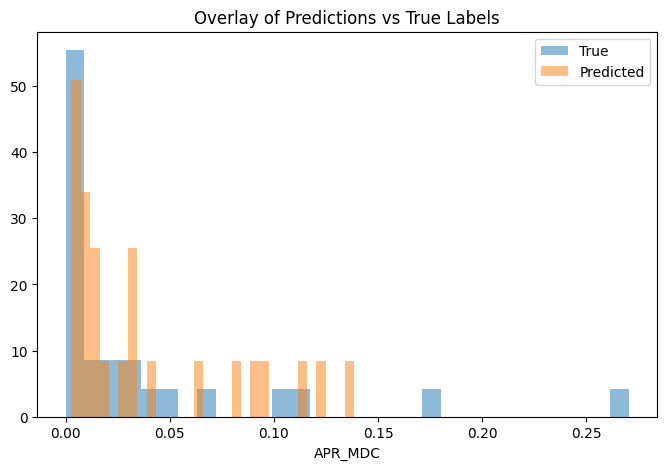

Jenson Shannon based similarity: Similarity between actual and synthetic datasets is 0.8272764641477564 percent


In [60]:


# Example usage
dist_match(df_pred['pred'].value_counts(normalize=True), df_train['APR_MDC'].value_counts(normalize=True),class_= "APR_MDC")
